# Enhanced Sentiment Analyser : Using Stacked Ensemble Learning (Conversational Dataset)
We use four tools namely BERT, VADER, Textblob and Flair to give sentiment scores all of which are fed to a Logistic Regressor First.

## Basic Data Loading and Checking the Base Models or Tools

In [435]:
!pip install pandas

In [436]:
!pip install textblob

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textblob
from scipy.spatial.distance import cdist
import seaborn as sns
import nltk
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [438]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [439]:
from textblob import TextBlob

In [440]:
newsheadline_corr_analysis  = pd.read_csv('Conversational_dataset.csv').sample(10000)




In [441]:
newsheadline_corr_analysis.head()


,Unnamed: 0,Dialogue,sentiment
9409,47762,"Oh , that's fantastic !",1
9875,49139,"Well , my parents have rented a condominium i...",1
6770,39891,"It's very nice , I like it very much .",1
10696,51837,Thank you very much .,1
14428,88370,Goodbye . Thanks again .,1


In [442]:


# Assuming you have a dataset 'original_data' with a 'class' column
class_0_data = newsheadline_corr_analysis[newsheadline_corr_analysis['sentiment'] == -1]
class_1_data = newsheadline_corr_analysis[newsheadline_corr_analysis['sentiment'] == 1]

# Calculate the size of the balanced sample for each class
sample_size_per_class = 1000

# Randomly sample data from each class
sampled_class_0 = class_0_data.sample(n=sample_size_per_class, random_state=42)
sampled_class_1 = class_1_data.sample(n=sample_size_per_class, random_state=42)

# Combine the sampled data to create the balanced sample
balanced_sample = pd.concat([sampled_class_0, sampled_class_1])

# Shuffle the balanced sample
balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)


In [443]:
newsheadline_corr_analysis = balanced_sample
newsheadline_corr_analysis.head()

,Unnamed: 0,Dialogue,sentiment
0,50368,"Well , the life style is much more relaxed th...",1
1,75655,I have a complaint to make . I've just been ba...,-1
2,43391,"Yes , orange juice will be fine for me . But ...",1
3,18291,Your best isn't good enough . Back in my day ...,-1
4,42665,"Happy Women's Day . I love you forever , Mum .",1


In [444]:
newsheadline_corr_analysis.rename(columns={'Dialogue':'Headline','sentiment':'Sentiment'},inplace = True  )

In [445]:
newsheadline_corr_analysis['Sentiment'].value_counts()

 1    1000
-1    1000
Name: Sentiment, dtype: int64

In [447]:
newsheadline_corr_analysis.to_csv('conversational_test.csv')

In [448]:
import seaborn as sns
import matplotlib

### About Flair

FLAIR Tagging -  language model (in yellow) and the sequence tagging (labeling) model (in blue). The bidirectional character language model receives the original text as input and computes contextual embeddings for each word. These are then passed into a BiLSTM-CRF sequence labeler. This special type of labeler makes use of a bidirectional LSTM (BiLSTM) recurrent neural model combined with a Conditional Random Field (CRF) – a type of combinatorial algorithm. It outputs the probability distribution of labels corresponding to individual words. The most probable label is then chosen for each word (as seen in the preceding figure in the top row). For example, the word Washington is labeled as E-PER in the preceding
figure, where PER suggests the word relates to a person and E marks the ending of a two-word named entity chunk. Words are often also tagged with a special label, O (meaning other), used for words not considered named entities or named entities belonging to none of the defined categories.
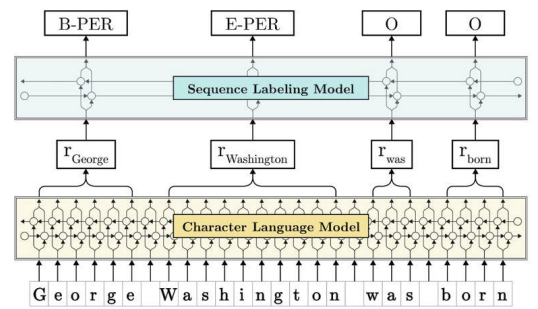

In [449]:
import flair

In [450]:
flair_model = flair.models.TextClassifier.load('en-sentiment')
def process_flair(dialogue):   # returning the flair score
    sentence = flair.data.Sentence(dialogue)
    flair_model.predict(sentence)
    label = sentence.labels[0].value
    score = sentence.labels[0].score
    if label == 'POSITIVE':
        return score
    elif label == 'NEGATIVE':
        return -score

In [451]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [452]:
def return_sentiment(txt):  # returning single-sentence BERT score
    encoded_input = tokenizer(txt, return_tensors='pt',padding=True,truncation=True)
    output = bert_model(**encoded_input)
    score = output[0][0].detach().numpy() 
    scores = softmax(score)
    if np.argsort(scores)[2] == 1:
        return 0
    else:
        return (np.argsort(scores)[2]-1)*scores[np.argsort(scores)[2]]

In [453]:
def cal_vader_textblob_bert_flair(txt):
    tb_score = TextBlob(txt).sentiment.polarity
    obj = SentimentIntensityAnalyzer()
    vader_score = obj.polarity_scores(txt)['compound']
    flair_score = process_flair(txt)
    bert_score = return_sentiment(txt)
    #prob = logmodel3.predict_proba([[tb_score,vader_score,flair_score,bert_score]])[0]      
    return pd.Series({'vader':vader_score,'textblob': tb_score,'bert':bert_score,'flair':flair_score})


In [454]:
def tb_score(txt):
    sen = TextBlob(txt)
    return pd.Series({'tb': sen.sentiment.polarity})

In [455]:

newsheadline_corr_analysis.head()

,Unnamed: 0,Headline,Sentiment
0,50368,"Well , the life style is much more relaxed th...",1
1,75655,I have a complaint to make . I've just been ba...,-1
2,43391,"Yes , orange juice will be fine for me . But ...",1
3,18291,Your best isn't good enough . Back in my day ...,-1
4,42665,"Happy Women's Day . I love you forever , Mum .",1


In [456]:
newsheadline_corr_analysis['Sentiment'].astype(float)

0       1.0
1      -1.0
2       1.0
3      -1.0
4       1.0
       ... 
1995    1.0
1996    1.0
1997   -1.0
1998    1.0
1999    1.0
Name: Sentiment, Length: 2000, dtype: float64

In [457]:
newsheadline_corr_analysis['Sentiment'].value_counts(dropna=True)

 1    1000
-1    1000
Name: Sentiment, dtype: int64

In [458]:
newsheadline_corr_analysis = pd.concat([newsheadline_corr_analysis, newsheadline_corr_analysis['Headline'].apply(cal_vader_textblob_bert_flair)], axis=1)

In [459]:
newsheadline_corr_analysis.to_csv('conversational_test_results.csv')
newsheadline_corr_analysis = pd.read_csv('conversational_test_results.csv')

In [460]:
newsheadline_corr_analysis.head()

,Unnamed: 0,Unnamed: 0.1,Headline,Sentiment,vader,textblob,bert,flair
0,0,50368,"Well , the life style is much more relaxed th...",1,0.7082,0.625000,0.961384,0.947213
1,1,75655,I have a complaint to make . I've just been ba...,-1,-0.8074,-0.433333,-0.922043,-0.999424
2,2,43391,"Yes , orange juice will be fine for me . But ...",1,0.5423,0.233333,-0.524368,-0.999811
3,3,18291,Your best isn't good enough . Back in my day ...,-1,0.8169,0.389286,-0.832147,-0.961241
4,4,42665,"Happy Women's Day . I love you forever , Mum .",1,0.8360,0.650000,0.988252,0.991436


In [461]:
newsheadline_corr_analysis['Sentiment'].astype(float)

0       1.0
1      -1.0
2       1.0
3      -1.0
4       1.0
       ... 
1995    1.0
1996    1.0
1997   -1.0
1998    1.0
1999    1.0
Name: Sentiment, Length: 2000, dtype: float64

In [462]:
newsheadline_corr_analysis['Sentiment'].value_counts()


 1    1000
-1    1000
Name: Sentiment, dtype: int64

def senti_adjust(score):
    if score == 0:
        return float(-1.0)
    else:
        return float(1.0)

In [463]:
float(1)

1.0

In [464]:
#newsheadline_corr_analysis['Sentiment'] = newsheadline_corr_analysis.apply(lambda x: senti_adjust(x['Sentiment']), axis=1)

In [465]:
newsheadline_corr_analysis['Sentiment'].astype(float)

0       1.0
1      -1.0
2       1.0
3      -1.0
4       1.0
       ... 
1995    1.0
1996    1.0
1997   -1.0
1998    1.0
1999    1.0
Name: Sentiment, Length: 2000, dtype: float64

# START HERE for loading from saved data

In [466]:
#newsheadline_corr_analysis.to_csv('amazon_test_results.csv')
newsheadline_corr_analysis = pd.read_csv('conversational_test_results.csv')

In [467]:
newsheadline_corr_analysis

,Unnamed: 0,Unnamed: 0.1,Headline,Sentiment,vader,textblob,bert,flair
0,0,50368,"Well , the life style is much more relaxed th...",1,0.7082,0.625000,0.961384,0.947213
1,1,75655,I have a complaint to make . I've just been ba...,-1,-0.8074,-0.433333,-0.922043,-0.999424
2,2,43391,"Yes , orange juice will be fine for me . But ...",1,0.5423,0.233333,-0.524368,-0.999811
3,3,18291,Your best isn't good enough . Back in my day ...,-1,0.8169,0.389286,-0.832147,-0.961241
4,4,42665,"Happy Women's Day . I love you forever , Mum .",1,0.8360,0.650000,0.988252,0.991436
...,...,...,...,...,...,...,...,...
1995,1995,6702,Thank you .,1,0.3612,0.000000,0.941535,0.921120
1996,1996,44170,"Oh , Mary , come in , please . I'm so happy to...",1,0.7425,0.800000,0.983824,0.995976
1997,1997,37295,I hate to see the abuse of animals .,-1,-0.8360,-0.800000,-0.939537,-0.997917
1998,1998,12770,"Happy birthday , John . Many happy returns of ...",1,0.8268,0.766667,0.986409,0.995637


In [468]:
def polarity(val):
    if val >= 0:
        return 1
    else:
        return -1
    
    

(array([532., 175.,  64.,   1., 435.,   0.,   2.,  61.,  87., 643.]),
 array([-0.95959288, -0.76449915, -0.56940541, -0.37431168, -0.17921795,
         0.01587579,  0.21096952,  0.40606325,  0.60115699,  0.79625072,
         0.99134445]),
 <a list of 10 Patch objects>)

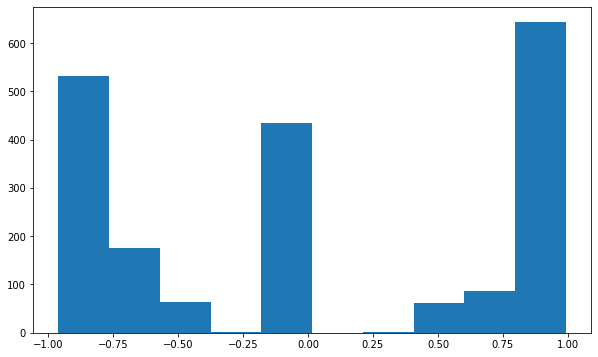

In [469]:
plt.hist(newsheadline_corr_analysis['bert'])


In [470]:
newsheadline_corr_analysis[['bert','vader','textblob','flair','Sentiment']].corr()

,bert,vader,textblob,flair,Sentiment
bert,1.000000,0.722911,0.651264,0.722975,0.816126
vader,0.722911,1.000000,0.607264,0.573792,0.608115
textblob,0.651264,0.607264,1.000000,0.497788,0.565209
flair,0.722975,0.573792,0.497788,1.000000,0.659630
Sentiment,0.816126,0.608115,0.565209,0.659630,1.000000


In [471]:
newsheadline_corr_analysis['vader_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['vader']), axis=1)
newsheadline_corr_analysis['textblob_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['textblob']), axis=1)
newsheadline_corr_analysis['bert_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['bert']), axis=1)
newsheadline_corr_analysis['flair_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['flair']), axis=1)

In [472]:
newsheadline_corr_analysis[['bert_polarity','vader_polarity','textblob_polarity','flair_polarity','Sentiment']].corr()

,bert_polarity,vader_polarity,textblob_polarity,flair_polarity,Sentiment
bert_polarity,1.000000,0.587820,0.526719,0.620097,0.743585
vader_polarity,0.587820,1.000000,0.515422,0.487012,0.519495
textblob_polarity,0.526719,0.515422,1.000000,0.419606,0.474061
flair_polarity,0.620097,0.487012,0.419606,1.000000,0.639899
Sentiment,0.743585,0.519495,0.474061,0.639899,1.000000


In [473]:
newsheadline_corr_analysis.head()

,Unnamed: 0,Unnamed: 0.1,Headline,Sentiment,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,0,50368,"Well , the life style is much more relaxed th...",1,0.7082,0.625000,0.961384,0.947213,1,1,1,1
1,1,75655,I have a complaint to make . I've just been ba...,-1,-0.8074,-0.433333,-0.922043,-0.999424,-1,-1,-1,-1
2,2,43391,"Yes , orange juice will be fine for me . But ...",1,0.5423,0.233333,-0.524368,-0.999811,1,1,-1,-1
3,3,18291,Your best isn't good enough . Back in my day ...,-1,0.8169,0.389286,-0.832147,-0.961241,1,1,-1,-1
4,4,42665,"Happy Women's Day . I love you forever , Mum .",1,0.8360,0.650000,0.988252,0.991436,1,1,1,1


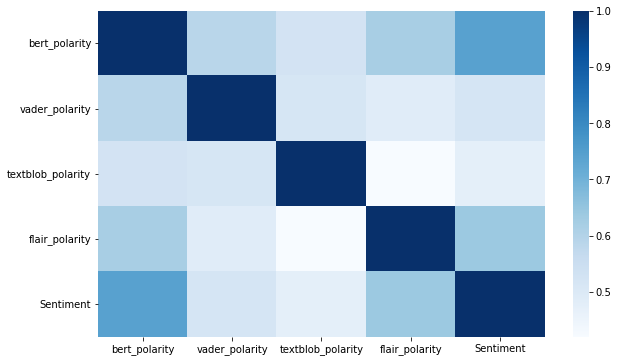

In [474]:
cordata = pd.DataFrame(newsheadline_corr_analysis[['bert_polarity','vader_polarity','textblob_polarity','flair_polarity','Sentiment']].corr())
cordata.to_csv('corrdata_conversational.csv')
sns.heatmap (cordata,cmap='Blues')

In [475]:
cordata.head()

,bert_polarity,vader_polarity,textblob_polarity,flair_polarity,Sentiment
bert_polarity,1.000000,0.587820,0.526719,0.620097,0.743585
vader_polarity,0.587820,1.000000,0.515422,0.487012,0.519495
textblob_polarity,0.526719,0.515422,1.000000,0.419606,0.474061
flair_polarity,0.620097,0.487012,0.419606,1.000000,0.639899
Sentiment,0.743585,0.519495,0.474061,0.639899,1.000000


In [476]:
newsheadline_corr_analysis = newsheadline_corr_analysis[(newsheadline_corr_analysis['vader'] != 0) |
                   (newsheadline_corr_analysis['textblob'] != 0) |
                   (newsheadline_corr_analysis['bert'] != 0) |
                   (newsheadline_corr_analysis['flair'] != 0) ]



In [477]:
newsheadline_corr_analysis[['vader','textblob','bert','flair','Sentiment']].corr()




,vader,textblob,bert,flair,Sentiment
vader,1.000000,0.607264,0.722911,0.573792,0.608115
textblob,0.607264,1.000000,0.651264,0.497788,0.565209
bert,0.722911,0.651264,1.000000,0.722975,0.816126
flair,0.573792,0.497788,0.722975,1.000000,0.659630
Sentiment,0.608115,0.565209,0.816126,0.659630,1.000000


In [478]:
newsheadline_corr_analysis.head()

,Unnamed: 0,Unnamed: 0.1,Headline,Sentiment,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,0,50368,"Well , the life style is much more relaxed th...",1,0.7082,0.625000,0.961384,0.947213,1,1,1,1
1,1,75655,I have a complaint to make . I've just been ba...,-1,-0.8074,-0.433333,-0.922043,-0.999424,-1,-1,-1,-1
2,2,43391,"Yes , orange juice will be fine for me . But ...",1,0.5423,0.233333,-0.524368,-0.999811,1,1,-1,-1
3,3,18291,Your best isn't good enough . Back in my day ...,-1,0.8169,0.389286,-0.832147,-0.961241,1,1,-1,-1
4,4,42665,"Happy Women's Day . I love you forever , Mum .",1,0.8360,0.650000,0.988252,0.991436,1,1,1,1


In [479]:
from sklearn import metrics
from sklearn.metrics import classification_report

#


### Vader

              precision    recall  f1-score   support

          -1       0.93      0.50      0.65      1000
           1       0.66      0.96      0.78      1000

    accuracy                           0.73      2000
   macro avg       0.79      0.73      0.72      2000
weighted avg       0.79      0.73      0.72      2000



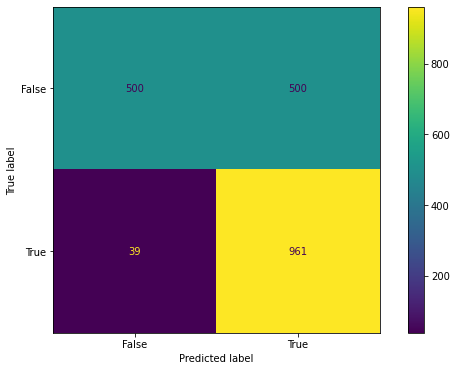

In [480]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['vader_polarity'])) # 
confusion_matrix_vader = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['vader_polarity'])
cm_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_vader, display_labels = [False, True])
cm_bert.plot()
plt.show()

### Textblob

              precision    recall  f1-score   support

          -1       0.91      0.45      0.61      1000
           1       0.64      0.96      0.76      1000

    accuracy                           0.70      2000
   macro avg       0.77      0.70      0.69      2000
weighted avg       0.77      0.70      0.69      2000



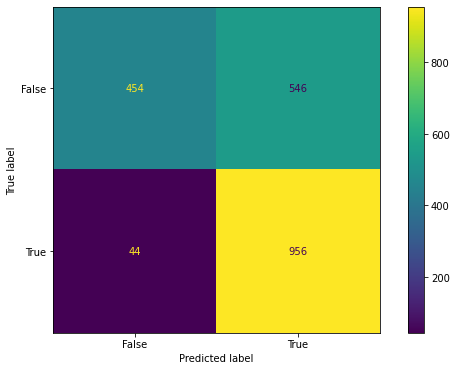

In [481]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['textblob_polarity'])) # 
confusion_matrix_tb = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['textblob_polarity'])
cm_tb = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_tb, display_labels = [False, True])
cm_tb.plot()
plt.show()

### Bert

              precision    recall  f1-score   support

          -1       0.97      0.75      0.84      1000
           1       0.79      0.98      0.88      1000

    accuracy                           0.86      2000
   macro avg       0.88      0.86      0.86      2000
weighted avg       0.88      0.86      0.86      2000



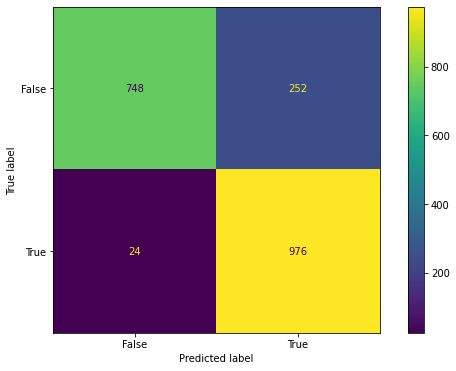

In [482]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['bert_polarity'])) # 
confusion_matrix_bert = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['bert_polarity'])
cm_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_bert, display_labels = [False, True])
cm_bert.plot()
plt.show()

### Flair

              precision    recall  f1-score   support

          -1       0.84      0.79      0.81      1000
           1       0.80      0.85      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



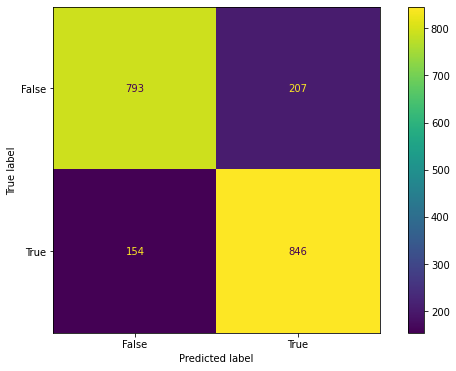

In [483]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['flair_polarity'])) # 
confusion_matrix_flair = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['flair_polarity'])
cm_flair = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_flair, display_labels = [False, True])
cm_flair.plot()
plt.show()

### Data analysis

In [484]:

newsheadline_corr_analysis.head()



,Unnamed: 0,Unnamed: 0.1,Headline,Sentiment,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,0,50368,"Well , the life style is much more relaxed th...",1,0.7082,0.625000,0.961384,0.947213,1,1,1,1
1,1,75655,I have a complaint to make . I've just been ba...,-1,-0.8074,-0.433333,-0.922043,-0.999424,-1,-1,-1,-1
2,2,43391,"Yes , orange juice will be fine for me . But ...",1,0.5423,0.233333,-0.524368,-0.999811,1,1,-1,-1
3,3,18291,Your best isn't good enough . Back in my day ...,-1,0.8169,0.389286,-0.832147,-0.961241,1,1,-1,-1
4,4,42665,"Happy Women's Day . I love you forever , Mum .",1,0.8360,0.650000,0.988252,0.991436,1,1,1,1


In [485]:
newsheadline_corr_analysis['Sentiment'].value_counts()
## This is a skewed dataset
# Therefore Precision - Recall curve will be bette than the ROC curve in this case

 1    1000
-1    1000
Name: Sentiment, dtype: int64

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

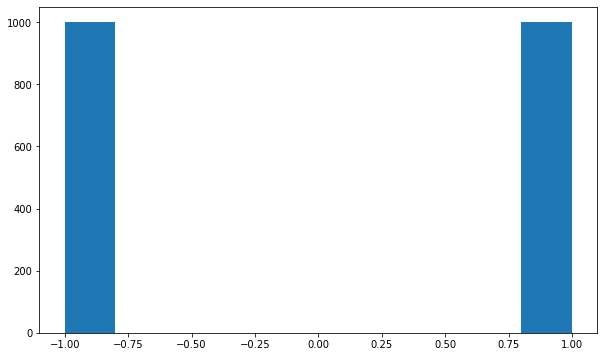

In [486]:
plt.hist(newsheadline_corr_analysis['Sentiment'])

## Training and Testing using Logistic Regressor

### Training and Checking 

In [487]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


In [488]:
mmscaler = MinMaxScaler()

In [489]:
logmodel = LogisticRegression()


In [490]:

our_data=newsheadline_corr_analysis



In [491]:
X = our_data[['textblob','vader','bert','flair','vader_polarity','textblob_polarity','bert_polarity','flair_polarity','Sentiment']]
y = our_data['Sentiment']

In [492]:
from sklearn.model_selection import train_test_split

In [493]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [494]:
y_test.shape



(600,)

In [495]:
X_train

,textblob,vader,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity,Sentiment
671,0.000,0.1891,-0.539095,0.999126,1,1,-1,1,1
247,0.500,0.3182,0.000000,0.990095,1,1,1,1,1
1782,0.700,0.4404,0.963083,0.983641,1,1,1,1,1
1884,0.000,0.5429,-0.698515,-0.999988,1,1,-1,-1,-1
354,-0.500,-0.0772,-0.832700,-0.998605,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
1993,0.600,0.4215,0.950262,0.989830,1,1,1,1,1
38,-0.025,0.8122,0.954324,0.997780,1,-1,1,1,1
957,-0.300,-0.5267,-0.939122,-0.998861,-1,-1,-1,-1,-1
1588,0.000,0.2023,0.000000,0.985174,1,1,1,1,1


In [496]:
X_train_full = X_train
X_train = X_train [['vader','textblob','bert','flair']]
X_train = mmscaler.fit_transform(X_train)

In [497]:
X_test_full = X_test
X_test = X_test [['vader','textblob','bert','flair']]
X_test = mmscaler.fit_transform(X_test)


In [498]:


logmodel.fit(X_train,y_train) # Outputs are -1 and 1

LogisticRegression()

In [499]:
X_train

array([[5.88863504e-01, 5.00000000e-01, 2.15536372e-01, 9.99572720e-01],
       [6.57457096e-01, 7.50000000e-01, 4.91862483e-01, 9.95057293e-01],
       [7.22384570e-01, 8.50000000e-01, 9.85513742e-01, 9.91829937e-01],
       ...,
       [2.08543648e-01, 3.50000000e-01, 1.04927709e-02, 5.68812990e-04],
       [5.95876946e-01, 5.00000000e-01, 4.91862483e-01, 9.92596341e-01],
       [7.43159237e-01, 6.87500000e-01, 9.92138289e-01, 9.97610723e-01]])

In [500]:
predictions = logmodel.predict(X_train)
probs = logmodel.predict_proba(X_train)


In [501]:
xx =pd.DataFrame([{'vader':.8,'textblob':.4,'bert':.8,'flair':.62}])
tem = logmodel.predict_proba(xx)
tem



/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.17707706, 0.82292294]])

In [502]:
probs.shape




(1400, 2)

In [503]:

probsdf = pd.DataFrame(probs)
probsdf['trth'] = y_train.to_numpy()
#aplha = 0.80
#high_prob_data = probsdf[(probsdf[1] > aplha) | (probsdf[0] > aplha)]
#probsdf = high_prob_data
probsdf.shape


(1400, 3)

### ROC Curve Analysis

In [504]:
import matplotlib
import matplotlib.pyplot as pyplot

Logistic: ROC AUC=0.962


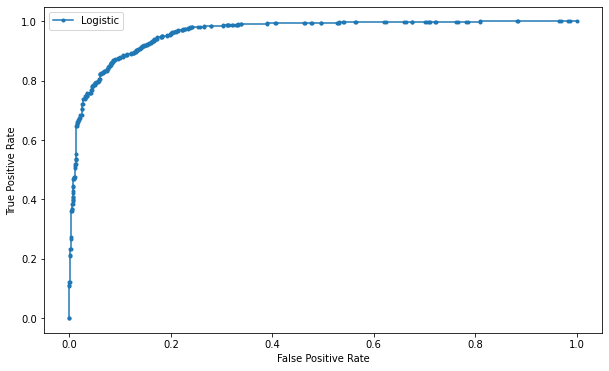

In [505]:
lr_probs = probs[:,[1]]
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_train, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [506]:
optimal_idx = np.argmax(lr_tpr - lr_fpr) #we need to maximise TP-FP
thr[optimal_idx]

0.5753171815526325

In [507]:
alpha_thresh = thr[optimal_idx]

def label_pol (prob_score):
    
    if prob_score[1] > alpha_thresh:
        return 1
    else:
       return -1


In [508]:
probsdf['label_pol_pred'] = probsdf.apply (lambda row: label_pol(row), axis=1)
probsdf.head()



,0,1,trth,label_pol_pred
0,0.745801,0.254199,1,-1
1,0.261687,0.738313,1,1
2,0.018494,0.981506,1,1
3,0.931654,0.068346,-1,-1
4,0.978888,0.021112,-1,-1


In [509]:
from sklearn import metrics
print(pd.DataFrame(metrics.classification_report(probsdf['trth'],probsdf['label_pol_pred'],output_dict=True)))




                   -1           1  accuracy    macro avg  weighted avg
precision    0.879287    0.906110  0.892143     0.892698      0.892622
recall       0.910511    0.873563  0.892143     0.892037      0.892143
f1-score     0.894627    0.889539  0.892143     0.892083      0.892097
support    704.000000  696.000000  0.892143  1400.000000   1400.000000



### Data Capture Threshold Analysis

In [510]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (4,92):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],probsdf['label_pol_pred'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)].count()/probsdf['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    threshold_analysis['Precision'] = res1['1'].loc['precision']
    threshold_analysis['Recall'] = res1['1'].loc['recall']
    threshold_analysis['f1'] = res1['1'].loc['f1-score']
    detl_threshold = detl_threshold.append(threshold_analysis)

In [511]:
res1

,-1,1,accuracy,macro avg,weighted avg
precision,0.987124,0.973029,0.979958,0.980077,0.980062
recall,0.972516,0.987368,0.979958,0.979942,0.979958
f1-score,0.979766,0.980146,0.979958,0.979956,0.979956
support,473.000000,475.000000,0.979958,948.000000,948.000000


In [512]:
detl_threshold.head()

,Thresh_alpha,Accuracy,Percent_data_capture,Precision,Recall,f1
0,0.04,0.892143,1.0,0.90611,0.873563,0.889539
0,0.05,0.892143,1.0,0.90611,0.873563,0.889539
0,0.06,0.892143,1.0,0.90611,0.873563,0.889539
0,0.07,0.892143,1.0,0.90611,0.873563,0.889539
0,0.08,0.892143,1.0,0.90611,0.873563,0.889539


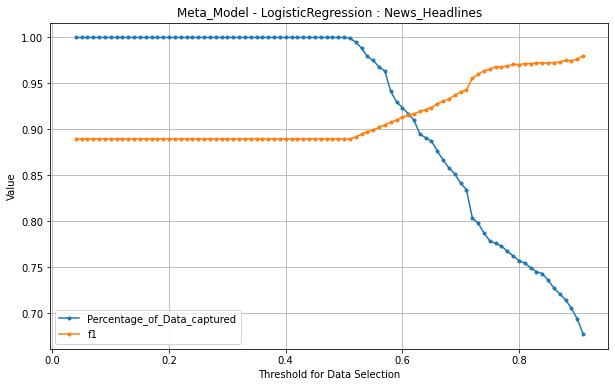

In [513]:
plt.rcParams['figure.figsize'] = [10, 6]
#pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
#pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
#pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Meta_Model - LogisticRegression : News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()  # we find that doe data selection threshold of 0.78 we should have good results; tradeoof is that we would miss 65% of dta and look at only 35% of data points for an assured accuracy of 90% and f1 score of approx .8

In [514]:
np.unique(y_train,return_counts = True)  # we realise that the dataset is not balanced

(array([-1,  1]), array([704, 696]))

### We look at Precision Recall curve which is more promising since this dataset is imbalanced.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

In [515]:
probsdf.head() # vector containing predicted prob for +1

,0,1,trth,label_pol_pred
0,0.745801,0.254199,1,-1
1,0.261687,0.738313,1,1
2,0.018494,0.981506,1,1
3,0.931654,0.068346,-1,-1
4,0.978888,0.021112,-1,-1


In [516]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, probsdf[1])


In [517]:
auc_pr = sklearn.metrics.auc(recall,precision)
auc_pr

0.9589752666881834

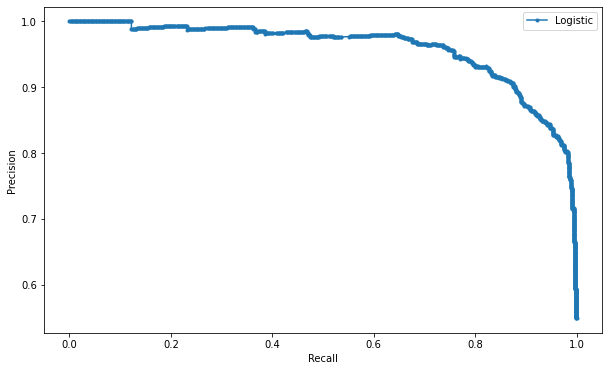

In [518]:
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Model Test

In [519]:
#we now test the logistic regressor
X_test.shape

(600, 4)

In [520]:
predictions_test = logmodel.predict(X_test)
probs_test = logmodel.predict_proba(X_test)

Logistic: ROC AUC=0.956


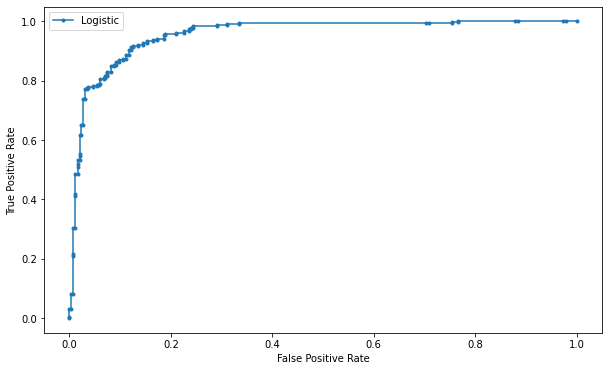

In [521]:
lr_probs = probs_test[:,[1]]
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_test, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [522]:
optimal_idx = np.argmax(lr_tpr - lr_fpr) #we need to maximise TP-FP
thr[optimal_idx]

0.4111667125197149

In [523]:
alpha_thresh = thr[optimal_idx]

def label_pol (prob_score):
    
    if prob_score[1] > alpha_thresh:
        return 1
    else:
       return -1

In [524]:
probsdf_test = pd.DataFrame(probs_test)
probsdf_test['trth'] = y_test.to_numpy()
probsdf_test['label_pol_pred'] = probsdf_test.apply (lambda row: label_pol(row), axis=1)
probsdf_test.head()


,0,1,trth,label_pol_pred
0,0.067862,0.932138,1,1
1,0.530962,0.469038,1,1
2,0.691637,0.308363,-1,-1
3,0.985181,0.014819,-1,-1
4,0.028772,0.971228,1,1


In [525]:
print(pd.DataFrame(metrics.classification_report(probsdf_test['trth'],probsdf_test['label_pol_pred'],output_dict=True)))

                   -1           1  accuracy   macro avg  weighted avg
precision    0.905923    0.884984     0.895    0.895454      0.895314
recall       0.878378    0.911184     0.895    0.894781      0.895000
f1-score     0.891938    0.897893     0.895    0.894916      0.894955
support    296.000000  304.000000     0.895  600.000000    600.000000


In [526]:
probsdf_test[['trth','label_pol_pred']].corr()

,trth,label_pol_pred
trth,1.000000,0.790235
label_pol_pred,0.790235,1.000000


In [527]:
alpha_th_test = .7
probsdf_test['trth'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test)].count()

512

In [528]:
print(pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test) ],probsdf_test['label_pol_pred'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test)],output_dict=True)))

                   -1           1  accuracy   macro avg  weighted avg
precision    0.928302    0.955466  0.941406    0.941884      0.941831
recall       0.957198    0.925490  0.941406    0.941344      0.941406
f1-score     0.942529    0.940239  0.941406    0.941384      0.941388
support    257.000000  255.000000  0.941406  512.000000    512.000000


In [529]:
probsdf_test['trth'][(probsdf_test[1]>alpha_th)|(probsdf_test[0]>alpha_th)].count()/probsdf_test['trth'].count()

0.6916666666666667

In [530]:
test_results=pd.DataFrame({'Prob':[],'label_pol_predict':[]})
test_results['Prob'] = probsdf_test[1]
test_results['label_pol_pred'] = probsdf_test['label_pol_pred']

### We need to analyse sentences
#### Also we need to compare with the four Base Models /  Tools

In [531]:
result_base_tools_tb = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['textblob_polarity'],output_dict=True))

In [532]:
result_base_tools_vader = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['vader_polarity'],output_dict=True))

In [533]:
result_base_tools_bert = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['bert_polarity'],output_dict=True))

In [534]:
result_base_tools_flair = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['flair_polarity'],output_dict=True))

In [535]:
result_base_tools_tb

,-1,1,accuracy,macro avg,weighted avg
precision,0.912409,0.630670,0.695,0.771539,0.769661
recall,0.422297,0.960526,0.695,0.691412,0.695000
f1-score,0.577367,0.761408,0.695,0.669388,0.670615
support,296.000000,304.000000,0.695,600.000000,600.000000


In [536]:
result_base_tools_vader

,-1,1,accuracy,macro avg,weighted avg
precision,0.926380,0.668192,0.738333,0.797286,0.795565
recall,0.510135,0.960526,0.738333,0.735331,0.738333
f1-score,0.657952,0.788124,0.738333,0.723038,0.723906
support,296.000000,304.000000,0.738333,600.000000,600.000000


In [537]:
result_base_tools_bert

,-1,1,accuracy,macro avg,weighted avg
precision,0.965665,0.806540,0.868333,0.886102,0.885042
recall,0.760135,0.973684,0.868333,0.866910,0.868333
f1-score,0.850662,0.882265,0.868333,0.866463,0.866674
support,296.000000,304.000000,0.868333,600.000000,600.000000


In [538]:
result_base_tools_flair

,-1,1,accuracy,macro avg,weighted avg
precision,0.832117,0.791411,0.81,0.811764,0.811493
recall,0.770270,0.848684,0.81,0.809477,0.810000
f1-score,0.800000,0.819048,0.81,0.809524,0.809651
support,296.000000,304.000000,0.81,600.000000,600.000000


In [539]:
probsdf_test[['tb','vader','bert','flair','textblob_polarity','vader_polarity','bert_polarity','flair_polarity'	]] = X_test_full[['vader','vader','bert','flair','textblob_polarity','vader_polarity','bert_polarity','flair_polarity']].to_numpy()

In [540]:
probsdf_test

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity
0,0.067862,0.932138,1,1,0.7269,0.7269,0.939559,-0.681963,1.0,1.0,1.0,-1.0
1,0.530962,0.469038,1,1,0.3818,0.3818,0.000000,-0.892302,1.0,1.0,1.0,-1.0
2,0.691637,0.308363,-1,-1,0.4019,0.4019,-0.490856,0.984657,1.0,1.0,-1.0,1.0
3,0.985181,0.014819,-1,-1,-0.5267,-0.5267,-0.883854,-0.997766,-1.0,-1.0,-1.0,-1.0
4,0.028772,0.971228,1,1,0.8119,0.8119,0.889048,0.958995,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.012010,0.987990,1,1,0.6369,0.6369,0.961337,0.999744,1.0,1.0,1.0,1.0
596,0.019071,0.980929,1,1,0.8910,0.8910,0.979471,0.995846,1.0,1.0,1.0,1.0
597,0.049596,0.950404,1,1,0.5106,0.5106,0.748365,0.991570,1.0,1.0,1.0,1.0
598,0.965861,0.034139,-1,-1,-0.6369,-0.6369,-0.598312,-0.994702,-1.0,-1.0,-1.0,-1.0


In [541]:
abs(probsdf_test['vader']).describe()

count    600.000000
mean       0.383075
std        0.272092
min        0.000000
25%        0.102700
50%        0.419900
75%        0.611400
max        0.967400
Name: vader, dtype: float64

In [542]:
alpha_th_test = .48
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][abs(probsdf_test['vader'])>alpha_th_test],probsdf_test['vader_polarity'][abs(probsdf_test['vader'])>alpha_th_test],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.935484,0.892216,0.90393,0.913850,0.906575
recall,0.763158,0.973856,0.90393,0.868507,0.903930
f1-score,0.840580,0.931250,0.90393,0.885915,0.901159
support,76.000000,153.000000,0.90393,229.000000,229.000000


In [543]:
abs(probsdf_test['bert']).describe()

count    600.000000
mean       0.666366
std        0.362802
min        0.000000
25%        0.550151
50%        0.833683
75%        0.936909
max        0.990066
Name: bert, dtype: float64

In [544]:
alpha_th_test = .78
res2 =pd.DataFrame(metrics.classification_report(probsdf_test['trth'][abs(probsdf_test['bert'])>alpha_th_test],probsdf_test['label_pol_pred'][abs(probsdf_test['bert'])>alpha_th_test],output_dict=True))
res2

,-1,1,accuracy,macro avg,weighted avg
precision,0.980000,0.963158,0.970588,0.971579,0.970786
recall,0.954545,0.983871,0.970588,0.969208,0.970588
f1-score,0.967105,0.973404,0.970588,0.970255,0.970551
support,154.000000,186.000000,0.970588,340.000000,340.000000


In [545]:
try:
    res2['1']
except KeyError:
    0

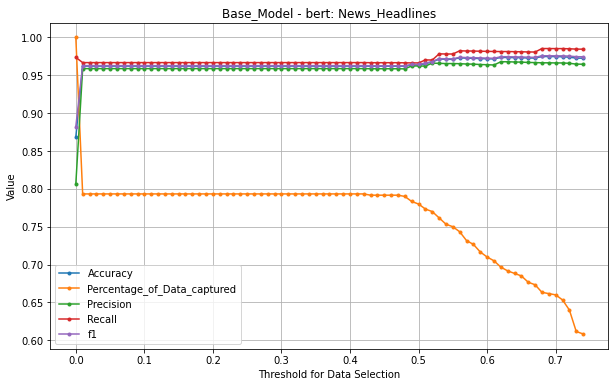

In [546]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,75):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['bert'])>=alpha_th],probsdf_test['bert_polarity'][abs(probsdf_test['bert'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].loc['precision']
    threshold_analysis['Percent_data_capture'] =  probsdf_test['trth'][abs(probsdf_test['bert'])>=alpha_th].count()/probsdf_test['trth'].count() if  probsdf_test['trth'].count()>0 else 0
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
    except KeyError:
        threshold_analysis['Precision']=0
    try:
        threshold_analysis['Recall'] = res1['1'].loc['recall']
    except KeyError:
       threshold_analysis['Recall'] =0
    try:
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['f1'] 
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - bert: News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

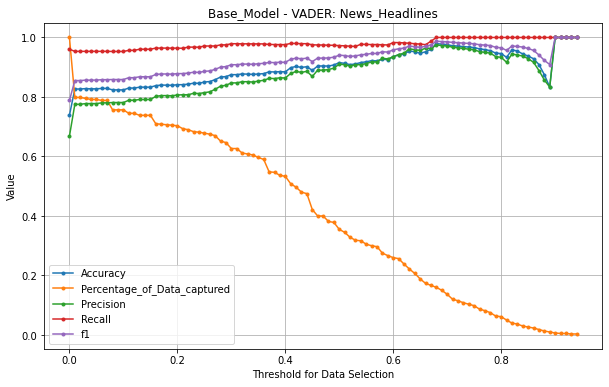

In [547]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['vader'])>=alpha_th],probsdf_test['vader_polarity'][abs(probsdf_test['vader'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['vader'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - VADER: News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

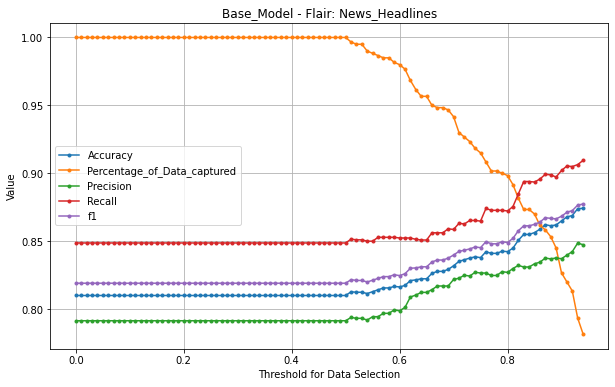

In [548]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['flair'])>=alpha_th],probsdf_test['flair_polarity'][abs(probsdf_test['flair'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['flair'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - Flair: News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

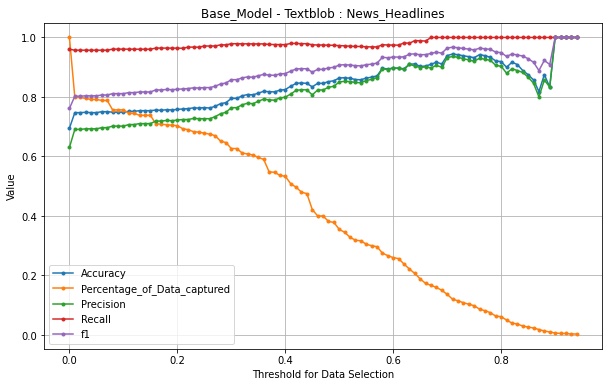

In [549]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['tb'])>=alpha_th],probsdf_test['textblob_polarity'][abs(probsdf_test['tb'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['tb'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - Textblob : News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [550]:
probsdf_test

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity
0,0.067862,0.932138,1,1,0.7269,0.7269,0.939559,-0.681963,1.0,1.0,1.0,-1.0
1,0.530962,0.469038,1,1,0.3818,0.3818,0.000000,-0.892302,1.0,1.0,1.0,-1.0
2,0.691637,0.308363,-1,-1,0.4019,0.4019,-0.490856,0.984657,1.0,1.0,-1.0,1.0
3,0.985181,0.014819,-1,-1,-0.5267,-0.5267,-0.883854,-0.997766,-1.0,-1.0,-1.0,-1.0
4,0.028772,0.971228,1,1,0.8119,0.8119,0.889048,0.958995,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.012010,0.987990,1,1,0.6369,0.6369,0.961337,0.999744,1.0,1.0,1.0,1.0
596,0.019071,0.980929,1,1,0.8910,0.8910,0.979471,0.995846,1.0,1.0,1.0,1.0
597,0.049596,0.950404,1,1,0.5106,0.5106,0.748365,0.991570,1.0,1.0,1.0,1.0
598,0.965861,0.034139,-1,-1,-0.6369,-0.6369,-0.598312,-0.994702,-1.0,-1.0,-1.0,-1.0


In [551]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [552]:


# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB())
]

# Iterate over classifiers and evaluate using cross-validation
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    print(f"{name} Mean Accuracy: {mean_score:.4f}")

# Choose the best model based on cross-validation scores
best_classifier = max(classifiers, key=lambda x: np.mean(cross_val_score(x[1], X_train, y_train, cv=5)))[1]

# Train the best classifier on the full training set
best_classifier.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Test Accuracy: {accuracy:.4f}")


Logistic Regression Mean Accuracy: 0.8843
Support Vector Machine Mean Accuracy: 0.8814
Random Forest Mean Accuracy: 0.8771
Naive Bayes Mean Accuracy: 0.8793
Best Model Test Accuracy: 0.8850


In [553]:
model_eval = pd.DataFrame({'Model':[],'Mean_Score':[]})

In [554]:
model_eval

,Model,Mean_Score


In [555]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model_eval = pd.DataFrame({'Model':[],'Mean_Score':[]})

# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Ridge Classifier', RidgeClassifier())
]

# Iterate over classifiers and evaluate using cross-validation
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    scores_temp = pd.DataFrame({'Model':[name],'Mean_Score':[mean_score]})
    model_eval = model_eval.append(scores_temp)
    print(f"{name} Mean Accuracy: {mean_score:.4f}")

# Choose the best model based on cross-validation scores
best_classifier = max(classifiers, key=lambda x: np.mean(cross_val_score(x[1], X_train, y_train, cv=5)))[1]

# Train the best classifier on the full training set
best_classifier.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Test Accuracy: {accuracy:.4f}")


Logistic Regression Mean Accuracy: 0.8843
Support Vector Machine Mean Accuracy: 0.8814
Random Forest Mean Accuracy: 0.8793
Naive Bayes Mean Accuracy: 0.8793
Decision Tree Mean Accuracy: 0.8536
Gradient Boosting Mean Accuracy: 0.8864
AdaBoost Mean Accuracy: 0.8921
Ridge Classifier Mean Accuracy: 0.8843
Best Model Test Accuracy: 0.8850


In [590]:
model_eval

,Model,Mean_Score
0,Logistic Regression,0.884286
0,Support Vector Machine,0.881429
0,Random Forest,0.879286
0,Naive Bayes,0.879286
0,Decision Tree,0.853571
0,Gradient Boosting,0.886429
0,AdaBoost,0.892143
0,Ridge Classifier,0.884286


In [591]:
model_eval.to_csv('conversational_model_eval.csv')

In [557]:
best_classifier

AdaBoostClassifier()

In [558]:

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,random_state=42,max_depth = 3)
# Train the classifier on the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))




Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.85      0.88       296
           1       0.87      0.91      0.89       304

    accuracy                           0.89       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.89      0.88       600



In [559]:
gb_classifier.predict([[-1,-1,-1,-1]])

array([-1])

In [560]:
y_probs = gb_classifier.predict_proba(X_train)
y_probs.shape

(1400, 2)

Logistic: ROC AUC=0.966


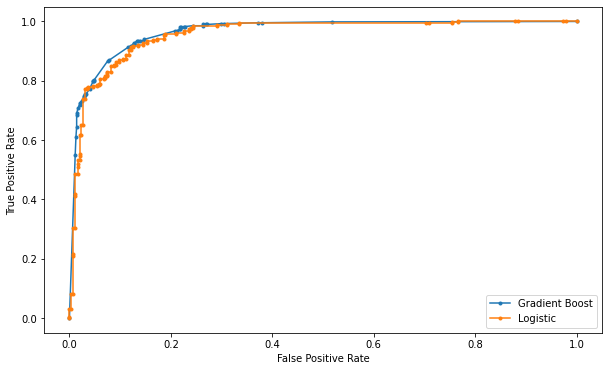

In [561]:
gb_probs = y_probs[:,[1]]
gb_auc = roc_auc_score(y_train, gb_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves

gb_fpr, gb_tpr, thr = roc_curve(y_train, gb_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: ROC AUC=0.962


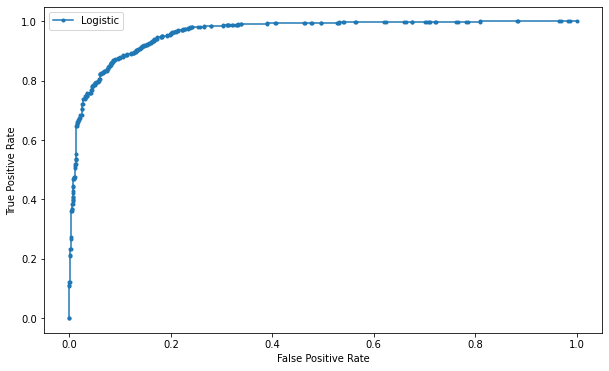

In [562]:
lr_probs = probs[:,[1]]
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_train, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [563]:
y_probs = gb_classifier.predict_proba(X_test)

Logistic: ROC AUC=0.956


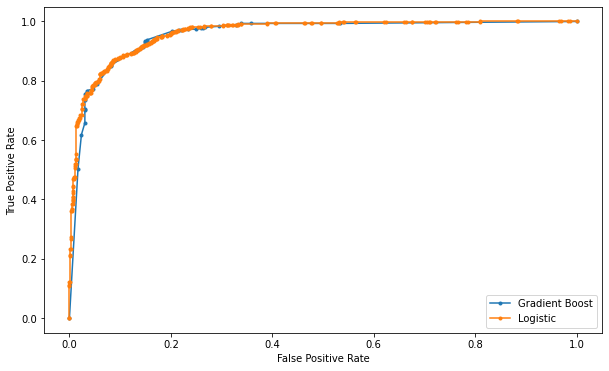

In [564]:
gb_probs = y_probs[:,[1]]
gb_auc = roc_auc_score(y_test, gb_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves

gb_fpr, gb_tpr, thr = roc_curve(y_test, gb_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [565]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

gb_classifier1 = GradientBoostingClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(gb_classifier1, param_grid, cv=3, scoring='accuracy')

# Perform hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Best Model:", best_model)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 150}
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.85      0.88       296
           1       0.87      0.92      0.89       304

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

Best Model: GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=150)


# Best Model Analysis
The best meta model was found to be GradientBoost. here after hyperparameter tuning we found the accuracy score to be 0.73
Now we will see if we can custom threshold and improve acuraccy.

In [566]:
probsdf_test['GBprobs_0']=gb_classifier.predict_proba(X_test)[:,0]
probsdf_test['GBprobs_1']=gb_classifier.predict_proba(X_test)[:,1]
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1
0,0.067862,0.932138,1,1,0.7269,0.7269,0.939559,-0.681963,1.0,1.0,1.0,-1.0,0.227807,0.772193
1,0.530962,0.469038,1,1,0.3818,0.3818,0.000000,-0.892302,1.0,1.0,1.0,-1.0,0.519037,0.480963
2,0.691637,0.308363,-1,-1,0.4019,0.4019,-0.490856,0.984657,1.0,1.0,-1.0,1.0,0.636809,0.363191
3,0.985181,0.014819,-1,-1,-0.5267,-0.5267,-0.883854,-0.997766,-1.0,-1.0,-1.0,-1.0,0.811347,0.188653
4,0.028772,0.971228,1,1,0.8119,0.8119,0.889048,0.958995,1.0,1.0,1.0,1.0,0.203791,0.796209


In [567]:
def Gb_polarity(val):
    if val >= 0.5:
        return 1
    else:
        return -1

In [568]:
probsdf_test['GBoost_polarity']= probsdf_test.apply (lambda x : Gb_polarity(x['GBprobs_1']),axis=1)
probsdf_test['GBoost_Pred']=gb_classifier.predict(X_test)

In [569]:
probsdf_test['trth1']=y_test

In [570]:
probsdf_test.head(15)

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.067862,0.932138,1,1,0.7269,0.7269,0.939559,-0.681963,1.0,1.0,1.0,-1.0,0.227807,0.772193,1,1,NaN
1,0.530962,0.469038,1,1,0.3818,0.3818,0.000000,-0.892302,1.0,1.0,1.0,-1.0,0.519037,0.480963,-1,-1,NaN
2,0.691637,0.308363,-1,-1,0.4019,0.4019,-0.490856,0.984657,1.0,1.0,-1.0,1.0,0.636809,0.363191,-1,-1,1.0
3,0.985181,0.014819,-1,-1,-0.5267,-0.5267,-0.883854,-0.997766,-1.0,-1.0,-1.0,-1.0,0.811347,0.188653,-1,-1,-1.0
4,0.028772,0.971228,1,1,0.8119,0.8119,0.889048,0.958995,1.0,1.0,1.0,1.0,0.203791,0.796209,1,1,NaN
5,0.037957,0.962043,1,1,0.8126,0.8126,0.909526,0.623441,1.0,1.0,1.0,1.0,0.227807,0.772193,1,1,NaN
6,0.018677,0.981323,1,1,0.6114,0.6114,0.970261,0.998986,1.0,1.0,1.0,1.0,0.203791,0.796209,1,1,-1.0
7,0.975786,0.024214,-1,-1,-0.5267,-0.5267,-0.845736,-0.999949,-1.0,-1.0,-1.0,-1.0,0.811347,0.188653,-1,-1,NaN
8,0.475224,0.524776,-1,1,0.0000,0.0000,0.000000,0.657879,1.0,1.0,1.0,1.0,0.458649,0.541351,1,1,-1.0
9,0.025638,0.974362,1,1,0.4404,0.4404,0.938804,0.999577,1.0,1.0,1.0,1.0,0.203791,0.796209,1,1,1.0


### Stacked Ensemble with Meta Model as LR : News_Headlines

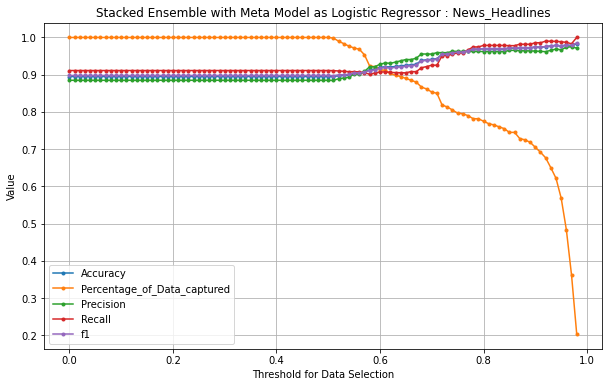

In [571]:

threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,99):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)],probsdf_test['label_pol_pred'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)].count()/probsdf_test[0].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Stacked Ensemble with Meta Model as Logistic Regressor : News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Stacked Ensemble with Meta Model as GradientBoost : News_Headlines

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

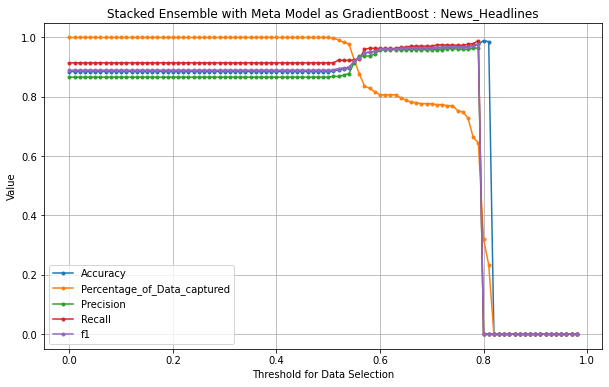

In [572]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,99):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)].count()/probsdf_test['GBprobs_1'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Stacked Ensemble with Meta Model as GradientBoost : News_Headlines')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [573]:
corr_analysis = probsdf_test[['label_pol_pred','GBoost_Pred','textblob_polarity','flair_polarity','vader_polarity','bert_polarity','trth']].corr()

In [574]:
probsdf_test[['label_pol_pred','GBoost_Pred','textblob_polarity','flair_polarity','vader_polarity','bert_polarity','trth']].corr().to_csv('final_corrdata_conversational.csv')

(array([221.,  18.,   8.,  19.,  39.,  11.,  18.,  38.,  24., 204.]),
 array([0.01040718, 0.10871615, 0.20702512, 0.30533408, 0.40364305,
        0.50195201, 0.60026098, 0.69856994, 0.79687891, 0.89518787,
        0.99349684]),
 <a list of 10 Patch objects>)

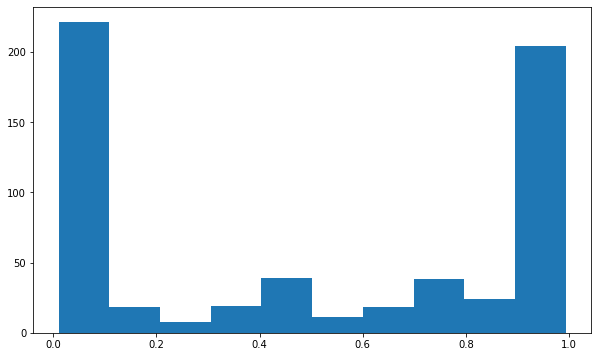

In [575]:
plt.hist(probsdf_test[0])

(array([239.,   2.,   2.,  13.,  65.,  33.,   5.,  16.,   2., 223.]),
 array([0.20379136, 0.26454689, 0.32530242, 0.38605794, 0.44681347,
        0.50756899, 0.56832452, 0.62908005, 0.68983557, 0.7505911 ,
        0.81134662]),
 <a list of 10 Patch objects>)

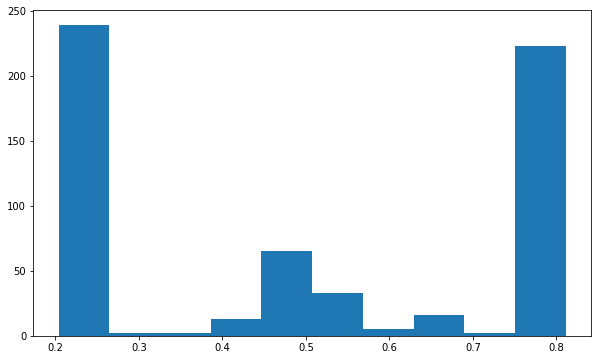

In [576]:
plt.hist(probsdf_test['GBprobs_0'])

In [577]:
dat = corr_analysis['trth'].to_numpy()

In [578]:
zz = corr_analysis.index

In [579]:
zz.to_list()

['label_pol_pred',
 'GBoost_Pred',
 'textblob_polarity',
 'flair_polarity',
 'vader_polarity',
 'bert_polarity',
 'trth']

In [580]:
dat

array([0.79023469, 0.77102637, 0.45596403, 0.62123695, 0.52900132,
       0.75276742, 1.        ])

# Final Analysis LR vs GBoost

In [581]:
alpha_th_test = 0
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.90681,0.866044,0.885,0.886427,0.886155
recall,0.85473,0.914474,0.885,0.884602,0.885000
f1-score,0.88000,0.889600,0.885,0.884800,0.884864
support,296.00000,304.000000,0.885,600.000000,600.000000


In [582]:
alpha_th_test = 0
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],probsdf_test['label_pol_pred'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.905923,0.884984,0.895,0.895454,0.895314
recall,0.878378,0.911184,0.895,0.894781,0.895000
f1-score,0.891938,0.897893,0.895,0.894916,0.894955
support,296.000000,304.000000,0.895,600.000000,600.000000


In [583]:
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.067862,0.932138,1,1,0.7269,0.7269,0.939559,-0.681963,1.0,1.0,1.0,-1.0,0.227807,0.772193,1,1,NaN
1,0.530962,0.469038,1,1,0.3818,0.3818,0.000000,-0.892302,1.0,1.0,1.0,-1.0,0.519037,0.480963,-1,-1,NaN
2,0.691637,0.308363,-1,-1,0.4019,0.4019,-0.490856,0.984657,1.0,1.0,-1.0,1.0,0.636809,0.363191,-1,-1,1.0
3,0.985181,0.014819,-1,-1,-0.5267,-0.5267,-0.883854,-0.997766,-1.0,-1.0,-1.0,-1.0,0.811347,0.188653,-1,-1,-1.0
4,0.028772,0.971228,1,1,0.8119,0.8119,0.889048,0.958995,1.0,1.0,1.0,1.0,0.203791,0.796209,1,1,NaN


In [584]:
conversational_vader_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['vader_polarity'],output_dict=True))
conversational_tb_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['textblob_polarity'],output_dict=True))
conversational_bert_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['bert_polarity'],output_dict=True))
conversational_flair_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['flair_polarity'],output_dict=True))

alpha_th_test = 0
conversational_gboost_acc = pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],output_dict=True))
conversational_LR_acc = pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],probsdf_test['label_pol_pred'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],output_dict=True))
conversational_acc_compare = pd.DataFrame({'Dataset':'conversational','Log_reg_meta':[0],'GBoost_meta':[0],'VADER':[0],'TextBlob':[0],'Flair':[0],'BERT':[0]})
conversational_acc_compare['GBoost_meta'].iloc[0]=conversational_gboost_acc['accuracy'].loc['precision']
conversational_acc_compare['Log_reg_meta'].iloc[0]=conversational_LR_acc['accuracy'].loc['precision']
conversational_acc_compare['VADER'].iloc[0]=conversational_vader_acc['accuracy'].loc['precision']
conversational_acc_compare['BERT'].iloc[0]=conversational_bert_acc['accuracy'].loc['precision']
conversational_acc_compare['Flair'].iloc[0]=conversational_flair_acc['accuracy'].loc['precision']
conversational_acc_compare['TextBlob'].iloc[0]=conversational_tb_acc['accuracy'].loc['precision']
conversational_acc_compare.to_csv('conversational_acc_analysis.csv')
conversational_acc_compare

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Dataset,Log_reg_meta,GBoost_meta,VADER,TextBlob,Flair,BERT
0,conversational,0.895,0.885,0.7305,0.705,0.8195,0.862


In [585]:
gb_classifier

GradientBoostingClassifier(learning_rate=0.01, random_state=42)

In [586]:
logmodel.predict([[-1,-1,-1,-1]])

array([-1])

In [587]:
gb_classifier.predict([[.2,.3,.5,.9]])

array([-1])

In [588]:
import joblib
  
# Save the trained model as a pickle string.
joblib.dump(gb_classifier,'conversational_gb_sav_model.pkl')
  
# Load the pickled model
#knn_from_pickle = pickle.loads(saved_model)

['conversational_gb_sav_model.pkl']

In [589]:
joblib.dump(logmodel, 'conversational_LR_sav_model.pkl')

['conversational_LR_sav_model.pkl']